In [ ]:
import os
import librosa
import librosa.display as lbd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from scipy import stats
from scipy.spatial.distance import euclidean, mahalanobis
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set paths for a sample pair (edit as needed)
REAL_DIR = 'data/real'
CLONED_DIR = 'data/cloned'

# Example: pick a speaker and file (edit these for your data)
speaker = os.listdir(REAL_DIR)[0]
real_files = [f for f in os.listdir(os.path.join(REAL_DIR, speaker)) if f.endswith('.wav')]
if not real_files:
    raise FileNotFoundError('No real wav files found!')
real_file = real_files[0]
real_path = os.path.join(REAL_DIR, speaker, real_file)
cloned_path = os.path.join(CLONED_DIR, speaker, real_file)

# Load audio
y_real, sr_real = librosa.load(real_path, sr=None)
y_clone, sr_clone = librosa.load(cloned_path, sr=None)

# Resample if needed
if sr_real != sr_clone:
    y_clone = librosa.resample(y_clone, orig_sr=sr_clone, target_sr=sr_real)
    sr_clone = sr_real

# Pad shorter signal for overlay
min_len = min(len(y_real), len(y_clone))
y_real = y_real[:min_len]
y_clone = y_clone[:min_len]


c:\Users\Pc\Desktop\LOCALS\Deep_Fake_Recognition\.venv310\lib\site-packages\lazy_loader\__init__.py:202: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Pc\Desktop\LOCALS\Deep_Fake_Recognition\.venv310\lib\site-packages\lazy_loader\__init__.py:202: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Pc\Desktop\LOCALS\Deep_Fake_Recognition\.venv310\lib\site-packages\librosa\core\intervals.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Re

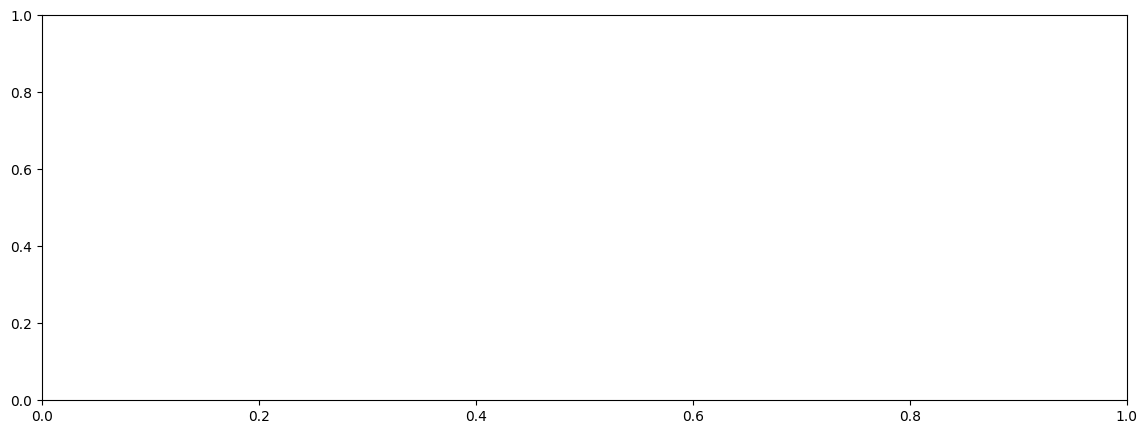

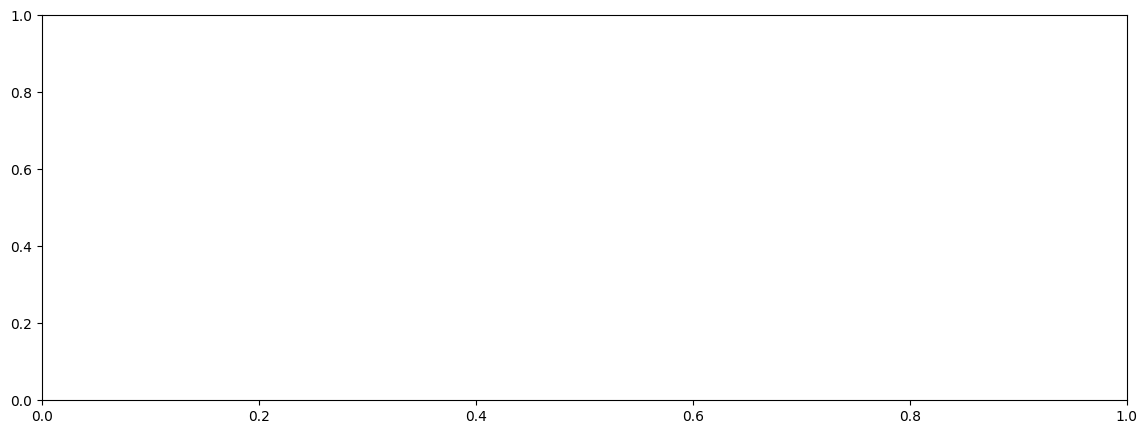

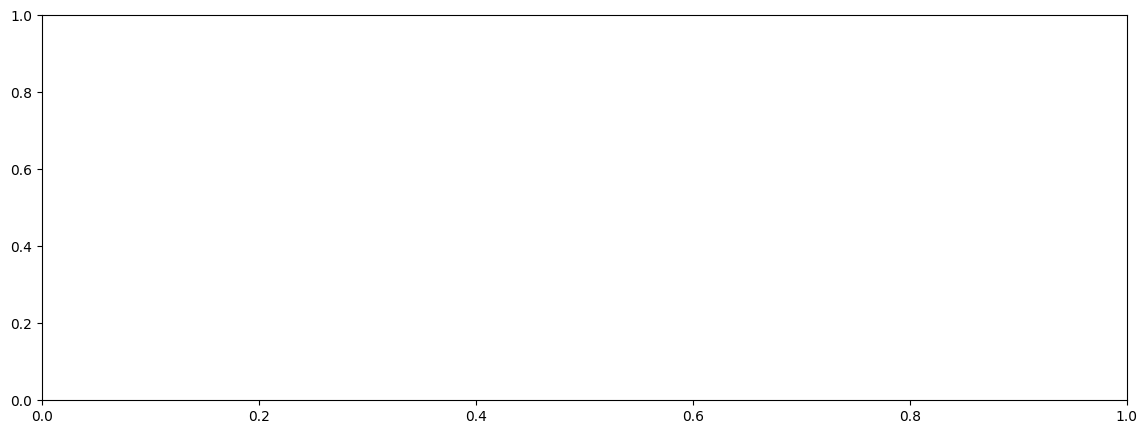

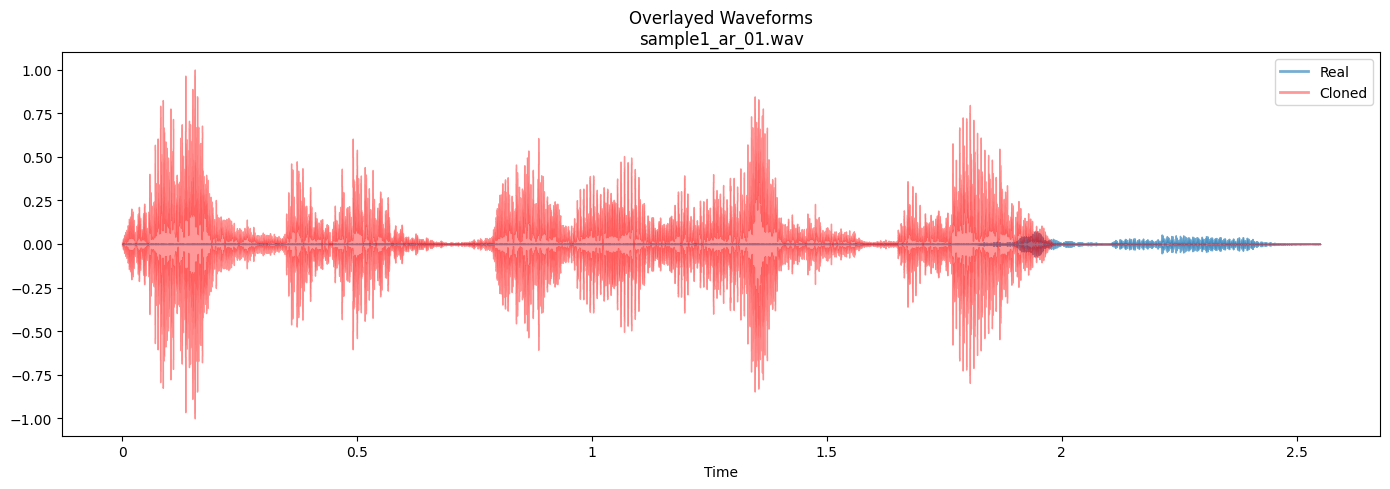

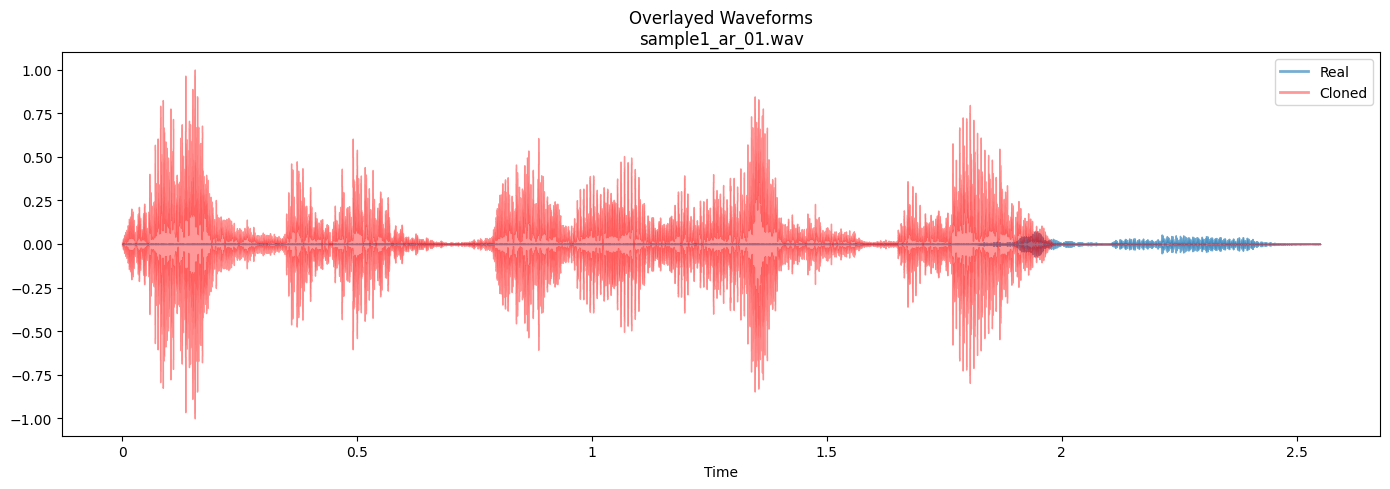

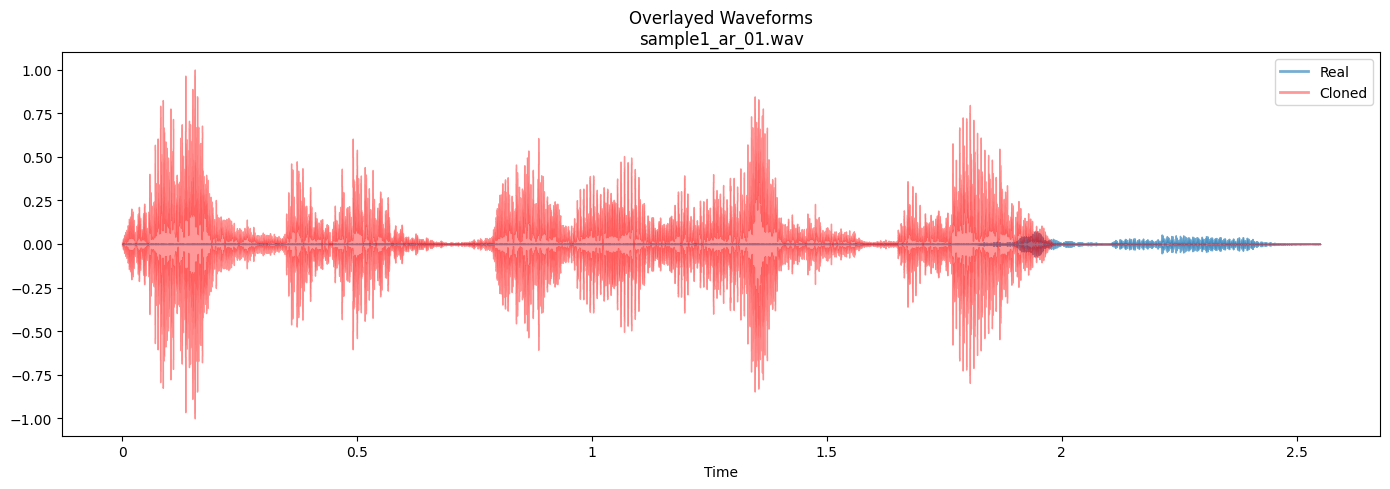

AttributeError: module 'matplotlib' has no attribute 'pyplot'

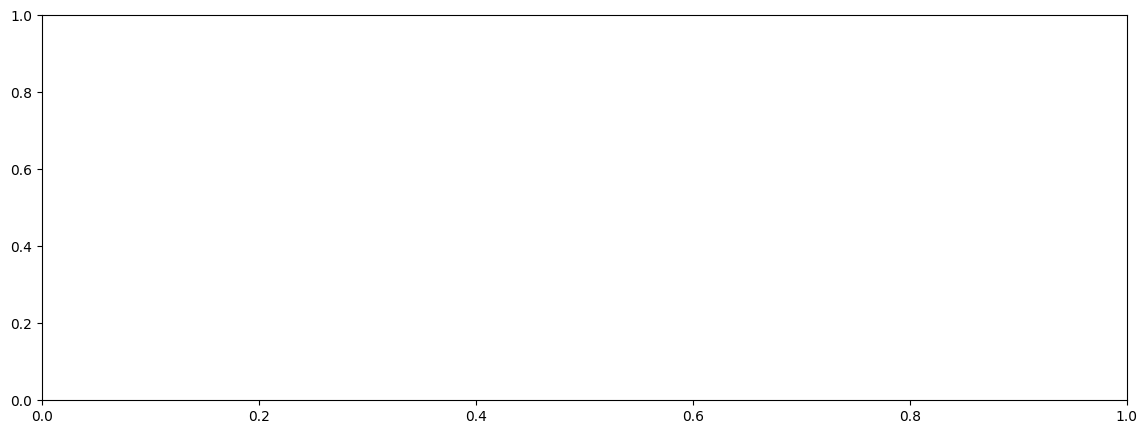

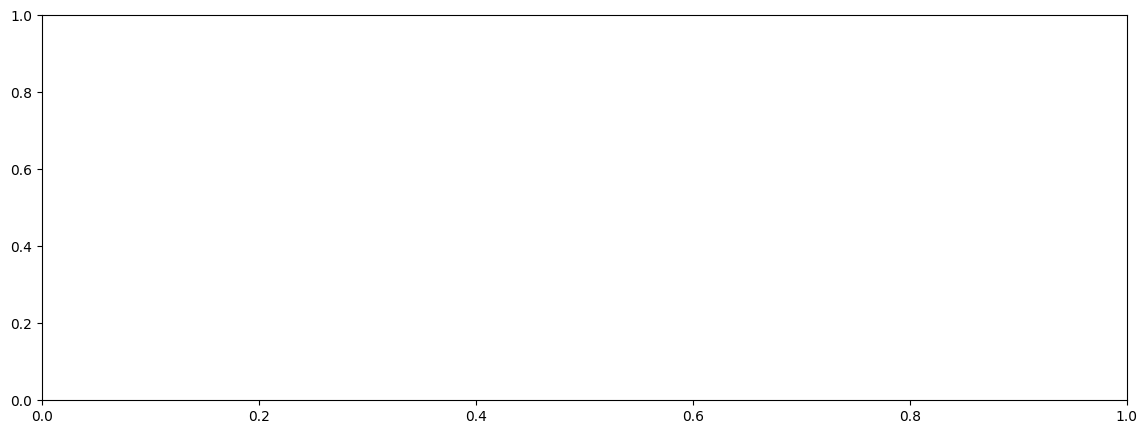

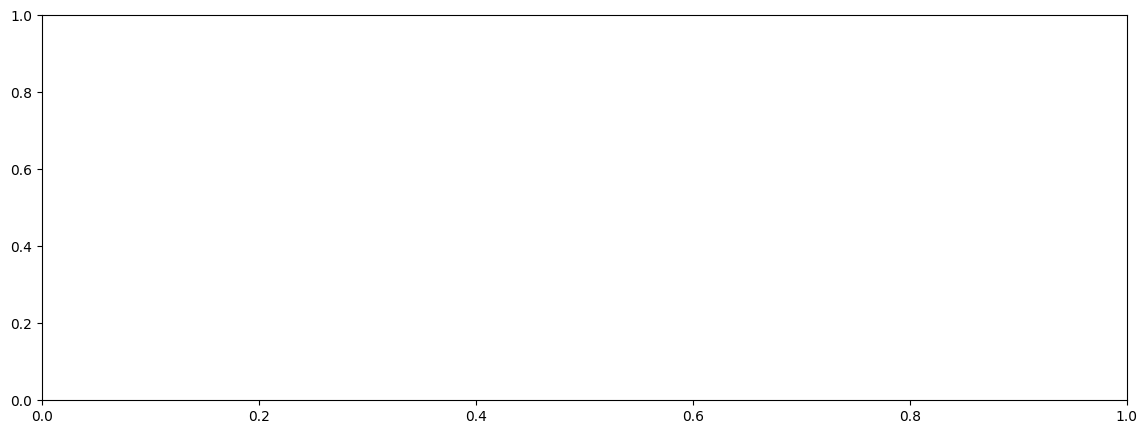

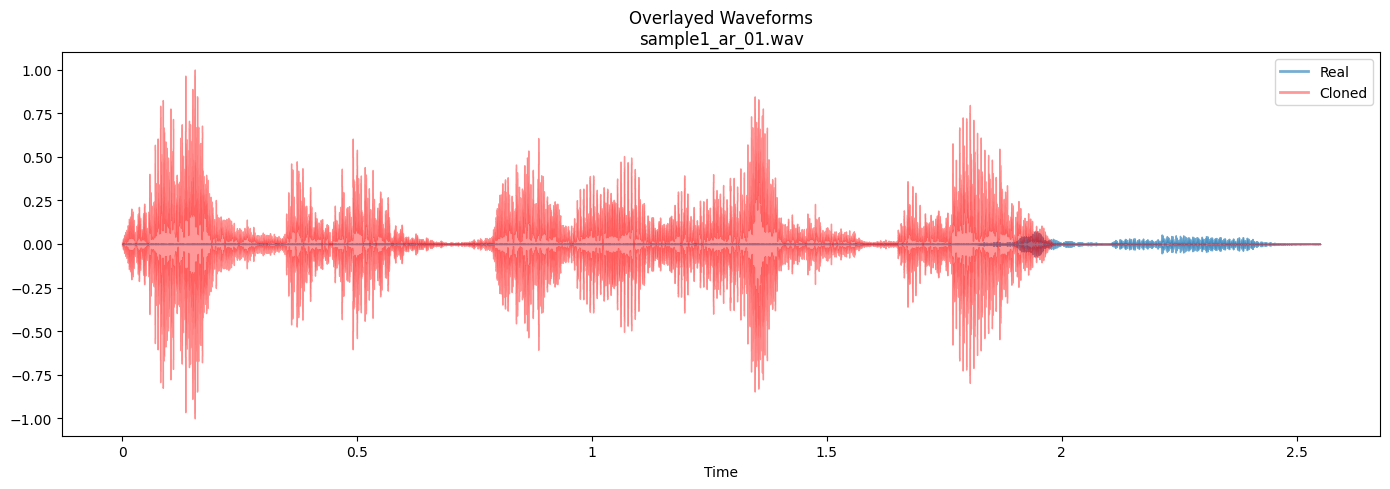

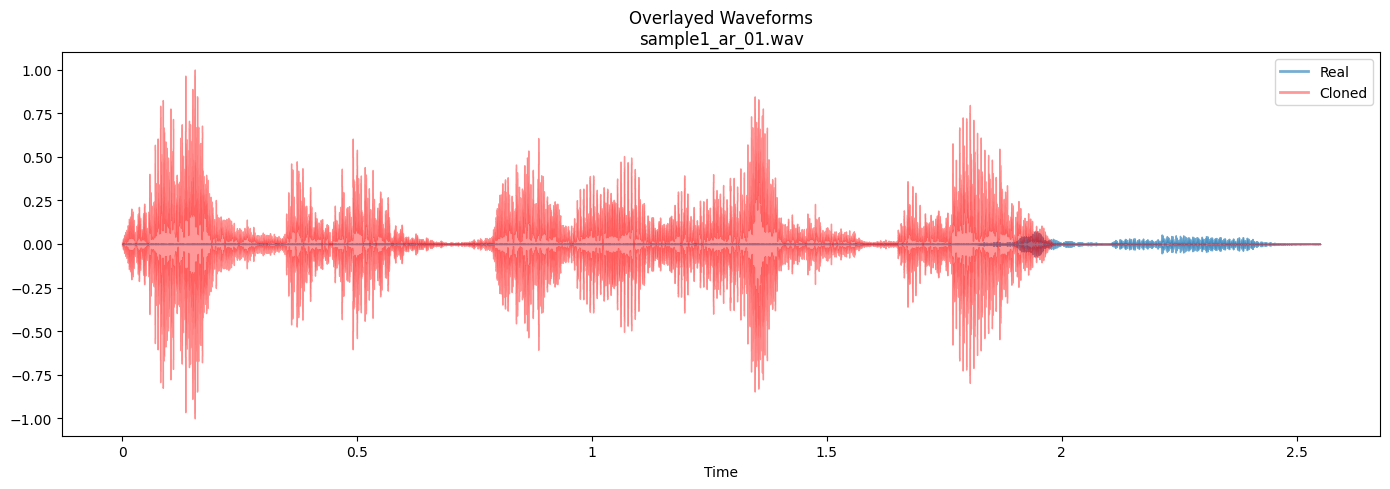

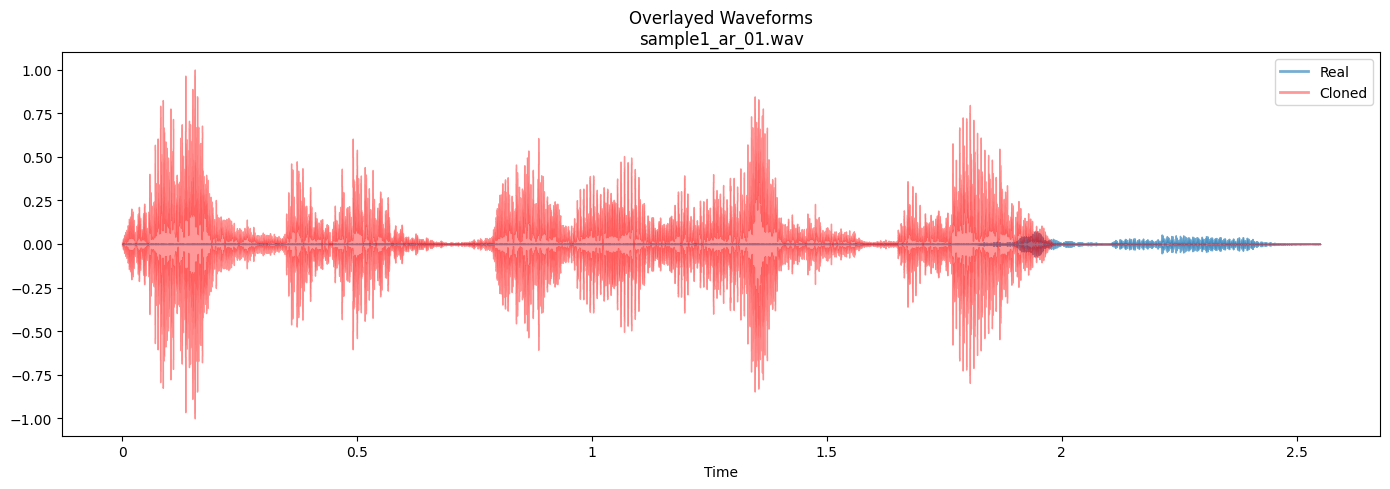

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [ ]:
plt.figure(figsize=(14, 5))
ax = plt.gca()
lbd.waveshow(y_real, sr=sr_real, alpha=0.6, ax=ax, color='C0')
lbd.waveshow(y_clone, sr=sr_real, alpha=0.4, ax=ax, color='r')
ax.set_title(f'Overlayed Waveforms\n{real_file}')
handles = [
    Line2D([0], [0], color='C0', lw=2, alpha=0.6, label='Real'),
    Line2D([0], [0], color='r', lw=2, alpha=0.4, label='Cloned')
]
labels = ['Real', 'Cloned']
ax.legend(handles, labels)
plt.tight_layout()
plt.show()

# Deepfake Voice Detection System - Feature Extraction and Analysis

This notebook implements a rule-based deepfake voice detection system using:
- MFCC features
- Delta and Delta-Delta features
- Fourier transform-based features
- Statistical analysis
- Hybrid scoring system


In [ ]:
# ============================================================================
# 1. MFCC Feature Extraction
# ============================================================================

def extract_mfcc(audio, sr=22050, n_mfcc=13, hop_length=512, n_fft=2048):
    """
    Extract MFCC features from audio signal.
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    sr : int
        Sample rate (default: 22050)
    n_mfcc : int
        Number of MFCC coefficients (default: 13)
    hop_length : int
        Number of samples between successive frames (default: 512)
    n_fft : int
        Length of the windowed signal (default: 2048)
    
    Returns:
    --------
    mfcc : np.ndarray
        MFCC features (n_mfcc x time_frames)
    """
    mfcc = librosa.feature.mfcc(
        y=audio,
        sr=sr,
        n_mfcc=n_mfcc,
        hop_length=hop_length,
        n_fft=n_fft
    )
    return mfcc

# Test MFCC extraction
print("Testing MFCC extraction...")
mfcc_real = extract_mfcc(y_real, sr_real)
mfcc_clone = extract_mfcc(y_clone, sr_clone)
print(f"Real audio MFCC shape: {mfcc_real.shape}")
print(f"Cloned audio MFCC shape: {mfcc_clone.shape}")


In [ ]:
# ============================================================================
# 2. Delta and Delta-Delta Feature Extraction
# ============================================================================

def extract_delta_features(mfcc):
    """
    Extract delta (first derivative) and delta-delta (second derivative) features.
    
    Parameters:
    -----------
    mfcc : np.ndarray
        MFCC features (n_mfcc x time_frames)
    
    Returns:
    --------
    delta : np.ndarray
        Delta features (n_mfcc x time_frames)
    delta_delta : np.ndarray
        Delta-delta features (n_mfcc x time_frames)
    """
    delta = librosa.feature.delta(mfcc)
    delta_delta = librosa.feature.delta(mfcc, order=2)
    return delta, delta_delta

# Test delta extraction
print("Testing Delta and Delta-Delta extraction...")
delta_real, delta_delta_real = extract_delta_features(mfcc_real)
delta_clone, delta_delta_clone = extract_delta_features(mfcc_clone)
print(f"Real audio Delta shape: {delta_real.shape}")
print(f"Real audio Delta-Delta shape: {delta_delta_real.shape}")
print(f"Cloned audio Delta shape: {delta_clone.shape}")
print(f"Cloned audio Delta-Delta shape: {delta_delta_clone.shape}")


In [ ]:
# ============================================================================
# 3. Fourier Transform Based Feature Extraction
# ============================================================================

def extract_fourier_features(audio, sr=22050, hop_length=512, n_fft=2048):
    """
    Extract Fourier transform-based features from audio signal.
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    sr : int
        Sample rate (default: 22050)
    hop_length : int
        Number of samples between successive frames (default: 512)
    n_fft : int
        Length of the windowed signal (default: 2048)
    
    Returns:
    --------
    features : dict
        Dictionary containing:
        - spectral_centroid: Spectral centroid
        - spectral_rolloff: Spectral rolloff
        - zero_crossing_rate: Zero crossing rate
        - spectral_bandwidth: Spectral bandwidth
        - mel_spectrogram: Mel spectrogram
    """
    # Compute Short-Time Fourier Transform
    stft = librosa.stft(audio, hop_length=hop_length, n_fft=n_fft)
    magnitude = np.abs(stft)
    
    # Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(
        y=audio, sr=sr, hop_length=hop_length, n_fft=n_fft
    )
    spectral_rolloff = librosa.feature.spectral_rolloff(
        y=audio, sr=sr, hop_length=hop_length, n_fft=n_fft
    )
    zero_crossing_rate = librosa.feature.zero_crossing_rate(
        audio, hop_length=hop_length, frame_length=n_fft
    )
    spectral_bandwidth = librosa.feature.spectral_bandwidth(
        y=audio, sr=sr, hop_length=hop_length, n_fft=n_fft
    )
    
    # Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, hop_length=hop_length, n_fft=n_fft
    )
    
    return {
        'spectral_centroid': spectral_centroid,
        'spectral_rolloff': spectral_rolloff,
        'zero_crossing_rate': zero_crossing_rate,
        'spectral_bandwidth': spectral_bandwidth,
        'mel_spectrogram': mel_spectrogram
    }

# Test Fourier feature extraction
print("Testing Fourier transform feature extraction...")
fourier_real = extract_fourier_features(y_real, sr_real)
fourier_clone = extract_fourier_features(y_clone, sr_clone)
print("Real audio Fourier features:")
for key, value in fourier_real.items():
    print(f"  {key}: shape {value.shape}")
print("Cloned audio Fourier features:")
for key, value in fourier_clone.items():
    print(f"  {key}: shape {value.shape}")


In [ ]:
# ============================================================================
# 4. Statistical Analysis Functions
# ============================================================================

def compute_statistical_features(feature_matrix):
    """
    Compute statistical features from a feature matrix.
    
    Parameters:
    -----------
    feature_matrix : np.ndarray
        Feature matrix (n_features x time_frames)
    
    Returns:
    --------
    stats_dict : dict
        Dictionary containing statistical measures:
        - mean: Mean across time
        - std: Standard deviation across time
        - skewness: Skewness across time
        - kurtosis: Kurtosis across time
        - min: Minimum value
        - max: Maximum value
        - median: Median value
    """
    stats_dict = {
        'mean': np.mean(feature_matrix, axis=1),
        'std': np.std(feature_matrix, axis=1),
        'min': np.min(feature_matrix, axis=1),
        'max': np.max(feature_matrix, axis=1),
        'median': np.median(feature_matrix, axis=1)
    }
    
    # Compute skewness and kurtosis for each feature
    skewness = []
    kurtosis = []
    for i in range(feature_matrix.shape[0]):
        skewness.append(stats.skew(feature_matrix[i, :]))
        kurtosis.append(stats.kurtosis(feature_matrix[i, :]))
    
    stats_dict['skewness'] = np.array(skewness)
    stats_dict['kurtosis'] = np.array(kurtosis)
    
    return stats_dict

def extract_all_features(audio, sr=22050):
    """
    Extract all features (MFCC, Delta, Delta-Delta, Fourier) from audio.
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    sr : int
        Sample rate
    
    Returns:
    --------
    all_features : dict
        Dictionary containing all extracted features and their statistics
    """
    # MFCC features
    mfcc = extract_mfcc(audio, sr)
    delta, delta_delta = extract_delta_features(mfcc)
    
    # Fourier features
    fourier = extract_fourier_features(audio, sr)
    
    # Statistical features for each
    features = {
        'mfcc': mfcc,
        'delta': delta,
        'delta_delta': delta_delta,
        'fourier': fourier,
        'mfcc_stats': compute_statistical_features(mfcc),
        'delta_stats': compute_statistical_features(delta),
        'delta_delta_stats': compute_statistical_features(delta_delta)
    }
    
    # Statistical features for Fourier features
    for key, value in fourier.items():
        if value.ndim == 2:
            features[f'{key}_stats'] = compute_statistical_features(value)
    
    return features

# Test statistical analysis
print("Testing statistical feature extraction...")
features_real = extract_all_features(y_real, sr_real)
features_clone = extract_all_features(y_clone, sr_clone)
print("Feature extraction completed for both real and cloned audio.")


In [ ]:
# ============================================================================
# 5. Distance Metric Functions
# ============================================================================

def flatten_statistical_features(features):
    """
    Flatten statistical features into a single feature vector.
    
    Parameters:
    -----------
    features : dict
        Dictionary containing feature statistics
    
    Returns:
    --------
    feature_vector : np.ndarray
        Flattened feature vector
    """
    feature_list = []
    
    # Add MFCC statistics
    for stat_name in ['mean', 'std', 'skewness', 'kurtosis']:
        if f'mfcc_stats' in features and stat_name in features['mfcc_stats']:
            feature_list.append(features['mfcc_stats'][stat_name])
    
    # Add Delta statistics
    for stat_name in ['mean', 'std', 'skewness', 'kurtosis']:
        if f'delta_stats' in features and stat_name in features['delta_stats']:
            feature_list.append(features['delta_stats'][stat_name])
    
    # Add Delta-Delta statistics
    for stat_name in ['mean', 'std', 'skewness', 'kurtosis']:
        if f'delta_delta_stats' in features and stat_name in features['delta_delta_stats']:
            feature_list.append(features['delta_delta_stats'][stat_name])
    
    # Add Fourier feature statistics
    fourier_keys = ['spectral_centroid', 'spectral_rolloff', 'zero_crossing_rate', 
                    'spectral_bandwidth']
    for key in fourier_keys:
        stat_key = f'{key}_stats'
        if stat_key in features:
            for stat_name in ['mean', 'std', 'skewness', 'kurtosis']:
                if stat_name in features[stat_key]:
                    feature_list.append(features[stat_key][stat_name])
    
    if len(feature_list) == 0:
        return np.array([])
    
    return np.concatenate(feature_list)

def compute_distance_metrics(test_features, reference_features_list):
    """
    Compute distance metrics between test features and reference features.
    
    Parameters:
    -----------
    test_features : dict
        Features extracted from test audio
    reference_features_list : list
        List of feature dictionaries from reference (real) audio samples
    
    Returns:
    --------
    distances : dict
        Dictionary containing:
        - euclidean_distances: List of Euclidean distances
        - mean_euclidean: Mean Euclidean distance
        - min_euclidean: Minimum Euclidean distance
        - max_euclidean: Maximum Euclidean distance
    """
    test_vector = flatten_statistical_features(test_features)
    
    if len(test_vector) == 0:
        return {'mean_euclidean': np.inf, 'min_euclidean': np.inf, 
                'max_euclidean': np.inf, 'euclidean_distances': []}
    
    euclidean_distances = []
    
    for ref_features in reference_features_list:
        ref_vector = flatten_statistical_features(ref_features)
        
        if len(ref_vector) == 0 or len(ref_vector) != len(test_vector):
            continue
        
        # Normalize vectors
        scaler = StandardScaler()
        combined = np.vstack([test_vector.reshape(1, -1), ref_vector.reshape(1, -1)])
        combined_scaled = scaler.fit_transform(combined)
        test_scaled = combined_scaled[0]
        ref_scaled = combined_scaled[1]
        
        # Compute Euclidean distance
        dist = euclidean(test_scaled, ref_scaled)
        euclidean_distances.append(dist)
    
    if len(euclidean_distances) == 0:
        return {'mean_euclidean': np.inf, 'min_euclidean': np.inf, 
                'max_euclidean': np.inf, 'euclidean_distances': []}
    
    return {
        'euclidean_distances': euclidean_distances,
        'mean_euclidean': np.mean(euclidean_distances),
        'min_euclidean': np.min(euclidean_distances),
        'max_euclidean': np.max(euclidean_distances),
        'std_euclidean': np.std(euclidean_distances)
    }

print("Distance metric functions defined.")


In [ ]:
# ============================================================================
# 6. Threshold-Based Detection
# ============================================================================

def compute_feature_thresholds(reference_features_list):
    """
    Compute thresholds for each feature based on reference (real) samples.
    
    Parameters:
    -----------
    reference_features_list : list
        List of feature dictionaries from reference (real) audio samples
    
    Returns:
    --------
    thresholds : dict
        Dictionary containing thresholds for each feature statistic
    """
    if len(reference_features_list) == 0:
        return {}
    
    # Collect all feature vectors
    all_vectors = []
    for ref_features in reference_features_list:
        vector = flatten_statistical_features(ref_features)
        if len(vector) > 0:
            all_vectors.append(vector)
    
    if len(all_vectors) == 0:
        return {}
    
    all_vectors = np.array(all_vectors)
    
    # Compute mean and std for each feature dimension
    mean_features = np.mean(all_vectors, axis=0)
    std_features = np.std(all_vectors, axis=0)
    
    # Thresholds: mean ± 2*std (95% confidence interval)
    thresholds = {
        'mean': mean_features,
        'std': std_features,
        'lower_bound': mean_features - 2 * std_features,
        'upper_bound': mean_features + 2 * std_features,
        'lower_bound_3sigma': mean_features - 3 * std_features,
        'upper_bound_3sigma': mean_features + 3 * std_features
    }
    
    return thresholds

def threshold_detection(test_features, thresholds):
    """
    Perform threshold-based detection.
    
    Parameters:
    -----------
    test_features : dict
        Features extracted from test audio
    thresholds : dict
        Thresholds computed from reference samples
    
    Returns:
    --------
    result : dict
        Dictionary containing:
        - threshold_score: Score based on how many features exceed thresholds (0-1)
        - features_outside_bounds: Number of features outside 2-sigma bounds
        - features_outside_3sigma: Number of features outside 3-sigma bounds
        - feature_violations: Detailed violation information
    """
    test_vector = flatten_statistical_features(test_features)
    
    if len(test_vector) == 0 or 'lower_bound' not in thresholds:
        return {
            'threshold_score': 0.5,
            'features_outside_bounds': 0,
            'features_outside_3sigma': 0,
            'feature_violations': []
        }
    
    if len(test_vector) != len(thresholds['lower_bound']):
        return {
            'threshold_score': 0.5,
            'features_outside_bounds': 0,
            'features_outside_3sigma': 0,
            'feature_violations': []
        }
    
    # Count features outside 2-sigma bounds
    outside_2sigma = np.sum(
        (test_vector < thresholds['lower_bound']) | 
        (test_vector > thresholds['upper_bound'])
    )
    
    # Count features outside 3-sigma bounds
    outside_3sigma = np.sum(
        (test_vector < thresholds['lower_bound_3sigma']) | 
        (test_vector > thresholds['upper_bound_3sigma'])
    )
    
    # Normalize score: more violations = higher fake score
    total_features = len(test_vector)
    threshold_score = (outside_2sigma / total_features) * 0.7 + (outside_3sigma / total_features) * 0.3
    
    return {
        'threshold_score': min(threshold_score, 1.0),
        'features_outside_bounds': int(outside_2sigma),
        'features_outside_3sigma': int(outside_3sigma),
        'total_features': total_features,
        'violation_ratio': outside_2sigma / total_features if total_features > 0 else 0
    }

print("Threshold detection functions defined.")


In [ ]:
# ============================================================================
# 7. Statistical Comparison Functions
# ============================================================================

def statistical_comparison(test_features, reference_features_list):
    """
    Compare test features statistically with reference features.
    
    Parameters:
    -----------
    test_features : dict
        Features extracted from test audio
    reference_features_list : list
        List of feature dictionaries from reference (real) audio samples
    
    Returns:
    --------
    comparison : dict
        Dictionary containing statistical comparison results
    """
    test_vector = flatten_statistical_features(test_features)
    
    if len(test_vector) == 0:
        return {'statistical_score': 0.5}
    
    # Collect all reference vectors
    ref_vectors = []
    for ref_features in reference_features_list:
        vector = flatten_statistical_features(ref_features)
        if len(vector) == len(test_vector):
            ref_vectors.append(vector)
    
    if len(ref_vectors) == 0:
        return {'statistical_score': 0.5}
    
    ref_vectors = np.array(ref_vectors)
    
    # Compute reference statistics
    ref_mean = np.mean(ref_vectors, axis=0)
    ref_std = np.std(ref_vectors, axis=0)
    
    # Compute z-scores for test vector
    z_scores = np.abs((test_vector - ref_mean) / (ref_std + 1e-10))
    
    # Score based on how many features have high z-scores
    high_z_score_count = np.sum(z_scores > 2.0)  # 2 standard deviations
    very_high_z_score_count = np.sum(z_scores > 3.0)  # 3 standard deviations
    
    total_features = len(test_vector)
    statistical_score = (
        (high_z_score_count / total_features) * 0.6 + 
        (very_high_z_score_count / total_features) * 0.4
    )
    
    return {
        'statistical_score': min(statistical_score, 1.0),
        'mean_z_score': np.mean(z_scores),
        'max_z_score': np.max(z_scores),
        'high_z_score_count': int(high_z_score_count),
        'very_high_z_score_count': int(very_high_z_score_count)
    }

print("Statistical comparison functions defined.")


In [ ]:
# ============================================================================
# 8. Hybrid Scoring System
# ============================================================================

def compute_hybrid_score(distance_metrics, threshold_result, statistical_result, 
                         weights=None):
    """
    Compute hybrid deepfake score combining multiple detection methods.
    
    Parameters:
    -----------
    distance_metrics : dict
        Results from distance metric computation
    threshold_result : dict
        Results from threshold-based detection
    statistical_result : dict
        Results from statistical comparison
    weights : dict, optional
        Weights for each component (default: equal weights)
        Keys: 'distance', 'threshold', 'statistical'
    
    Returns:
    --------
    score : float
        Hybrid deepfake score (0-1, where 1 = definitely fake)
    """
    if weights is None:
        weights = {
            'distance': 0.3,
            'threshold': 0.4,
            'statistical': 0.3
        }
    
    # Normalize distance score (higher distance = higher fake score)
    # Use inverse of normalized distance (normalize to 0-1 range)
    mean_dist = distance_metrics.get('mean_euclidean', 0)
    if mean_dist == np.inf or mean_dist == 0:
        distance_score = 0.5
    else:
        # Normalize distance (assuming typical range 0-10, adjust if needed)
        distance_score = min(mean_dist / 10.0, 1.0)
    
    # Threshold score (already 0-1)
    threshold_score = threshold_result.get('threshold_score', 0.5)
    
    # Statistical score (already 0-1)
    statistical_score = statistical_result.get('statistical_score', 0.5)
    
    # Weighted combination
    hybrid_score = (
        weights['distance'] * distance_score +
        weights['threshold'] * threshold_score +
        weights['statistical'] * statistical_score
    )
    
    # Ensure score is in [0, 1] range
    hybrid_score = max(0.0, min(1.0, hybrid_score))
    
    return {
        'hybrid_score': hybrid_score,
        'distance_score': distance_score,
        'threshold_score': threshold_score,
        'statistical_score': statistical_score,
        'components': {
            'distance': distance_score,
            'threshold': threshold_score,
            'statistical': statistical_score
        }
    }

print("Hybrid scoring system defined.")


In [ ]:
# ============================================================================
# 9. Main Deepfake Detection Function
# ============================================================================

def load_reference_samples(real_dir, max_samples=None):
    """
    Load reference (real) audio samples and extract their features.
    
    Parameters:
    -----------
    real_dir : str
        Directory containing real audio samples
    max_samples : int, optional
        Maximum number of samples to load (None = all)
    
    Returns:
    --------
    reference_features_list : list
        List of feature dictionaries from reference samples
    """
    reference_features_list = []
    
    if not os.path.exists(real_dir):
        print(f"Warning: Real directory {real_dir} does not exist.")
        return reference_features_list
    
    # Get all speaker directories
    speaker_dirs = [d for d in os.listdir(real_dir) 
                   if os.path.isdir(os.path.join(real_dir, d))]
    
    sample_count = 0
    for speaker_dir in speaker_dirs:
        speaker_path = os.path.join(real_dir, speaker_dir)
        wav_files = [f for f in os.listdir(speaker_path) if f.endswith('.wav')]
        
        for wav_file in wav_files:
            if max_samples is not None and sample_count >= max_samples:
                break
            
            wav_path = os.path.join(speaker_path, wav_file)
            try:
                audio, sr = librosa.load(wav_path, sr=22050)
                features = extract_all_features(audio, sr)
                reference_features_list.append(features)
                sample_count += 1
            except Exception as e:
                print(f"Error loading {wav_path}: {e}")
        
        if max_samples is not None and sample_count >= max_samples:
            break
    
    print(f"Loaded {len(reference_features_list)} reference samples.")
    return reference_features_list

def detect_deepfake(audio_path, reference_real_samples=None, real_dir=None, 
                   threshold=0.5, weights=None):
    """
    Detect if an audio file is a deepfake (cloned) or real.
    
    Parameters:
    -----------
    audio_path : str
        Path to the audio file to test
    reference_real_samples : list, optional
        List of feature dictionaries from reference (real) samples.
        If None, will load from real_dir
    real_dir : str, optional
        Directory containing real audio samples (used if reference_real_samples is None)
    threshold : float
        Threshold for classification (default: 0.5)
        Score >= threshold -> fake, Score < threshold -> real
    weights : dict, optional
        Weights for hybrid scoring
    
    Returns:
    --------
    result : dict
        Dictionary containing:
        - is_fake: bool, True if detected as fake
        - score: float (0-1), deepfake score (1 = definitely fake)
        - confidence: float, confidence in the prediction
        - feature_analysis: dict, detailed feature analysis
    """
    # Load test audio
    try:
        audio, sr = librosa.load(audio_path, sr=22050)
    except Exception as e:
        return {
            'is_fake': None,
            'score': None,
            'confidence': 0.0,
            'error': str(e),
            'feature_analysis': {}
        }
    
    # Extract features from test audio
    test_features = extract_all_features(audio, sr)
    
    # Load reference samples if not provided
    if reference_real_samples is None:
        if real_dir is None:
            real_dir = REAL_DIR
        reference_real_samples = load_reference_samples(real_dir)
    
    if len(reference_real_samples) == 0:
        return {
            'is_fake': None,
            'score': 0.5,
            'confidence': 0.0,
            'error': 'No reference samples available',
            'feature_analysis': {}
        }
    
    # Compute distance metrics
    distance_metrics = compute_distance_metrics(test_features, reference_real_samples)
    
    # Compute thresholds from reference samples
    thresholds = compute_feature_thresholds(reference_real_samples)
    
    # Threshold-based detection
    threshold_result = threshold_detection(test_features, thresholds)
    
    # Statistical comparison
    statistical_result = statistical_comparison(test_features, reference_real_samples)
    
    # Hybrid scoring
    hybrid_result = compute_hybrid_score(
        distance_metrics, threshold_result, statistical_result, weights
    )
    
    score = hybrid_result['hybrid_score']
    is_fake = score >= threshold
    
    # Compute confidence (distance from threshold)
    confidence = abs(score - threshold) * 2  # Normalize to 0-1
    confidence = min(1.0, confidence)
    
    return {
        'is_fake': is_fake,
        'score': score,
        'confidence': confidence,
        'threshold': threshold,
        'feature_analysis': {
            'distance_metrics': distance_metrics,
            'threshold_result': threshold_result,
            'statistical_result': statistical_result,
            'hybrid_components': hybrid_result['components']
        }
    }

print("Main detection function defined.")


In [ ]:
# ============================================================================
# 10. Test the Detection System
# ============================================================================

# Test with the sample files we loaded earlier
print("Testing detection system...")
print("\n" + "="*60)

# Test with real audio
print("\n1. Testing with REAL audio:")
result_real = detect_deepfake(real_path, real_dir=REAL_DIR, threshold=0.5)
print(f"   File: {real_file}")
print(f"   Is Fake: {result_real['is_fake']}")
print(f"   Deepfake Score: {result_real['score']:.4f}")
print(f"   Confidence: {result_real['confidence']:.4f}")
print(f"   Distance Score: {result_real['feature_analysis']['hybrid_components']['distance']:.4f}")
print(f"   Threshold Score: {result_real['feature_analysis']['hybrid_components']['threshold']:.4f}")
print(f"   Statistical Score: {result_real['feature_analysis']['hybrid_components']['statistical']:.4f}")

# Test with cloned audio
print("\n2. Testing with CLONED audio:")
result_clone = detect_deepfake(cloned_path, real_dir=REAL_DIR, threshold=0.5)
print(f"   File: {real_file}")
print(f"   Is Fake: {result_clone['is_fake']}")
print(f"   Deepfake Score: {result_clone['score']:.4f}")
print(f"   Confidence: {result_clone['confidence']:.4f}")
print(f"   Distance Score: {result_clone['feature_analysis']['hybrid_components']['distance']:.4f}")
print(f"   Threshold Score: {result_clone['feature_analysis']['hybrid_components']['threshold']:.4f}")
print(f"   Statistical Score: {result_clone['feature_analysis']['hybrid_components']['statistical']:.4f}")

print("\n" + "="*60)


# Visualizations


In [ ]:
# ============================================================================
# 11. MFCC Visualization
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Real audio MFCC
ax = axes[0, 0]
mfcc_display = lbd.specshow(mfcc_real, x_axis='time', y_axis='mel', sr=sr_real, ax=ax)
ax.set_title(f'MFCC - Real Audio\n{real_file}', fontsize=12, fontweight='bold')
plt.colorbar(mfcc_display, ax=ax, format='%+2.0f dB')

# Cloned audio MFCC
ax = axes[0, 1]
mfcc_display = lbd.specshow(mfcc_clone, x_axis='time', y_axis='mel', sr=sr_clone, ax=ax)
ax.set_title(f'MFCC - Cloned Audio\n{real_file}', fontsize=12, fontweight='bold')
plt.colorbar(mfcc_display, ax=ax, format='%+2.0f dB')

# Delta features comparison
ax = axes[1, 0]
delta_mean_real = np.mean(delta_real, axis=1)
delta_mean_clone = np.mean(delta_clone, axis=1)
x = np.arange(len(delta_mean_real))
width = 0.35
ax.bar(x - width/2, delta_mean_real, width, label='Real', alpha=0.7)
ax.bar(x + width/2, delta_mean_clone, width, label='Cloned', alpha=0.7)
ax.set_xlabel('MFCC Coefficient')
ax.set_ylabel('Mean Delta Value')
ax.set_title('Delta Features Comparison', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Delta-Delta features comparison
ax = axes[1, 1]
delta_delta_mean_real = np.mean(delta_delta_real, axis=1)
delta_delta_mean_clone = np.mean(delta_delta_clone, axis=1)
x = np.arange(len(delta_delta_mean_real))
ax.bar(x - width/2, delta_delta_mean_real, width, label='Real', alpha=0.7)
ax.bar(x + width/2, delta_delta_mean_clone, width, label='Cloned', alpha=0.7)
ax.set_xlabel('MFCC Coefficient')
ax.set_ylabel('Mean Delta-Delta Value')
ax.set_title('Delta-Delta Features Comparison', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# 12. Fourier Features Visualization
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Spectral Centroid
ax = axes[0, 0]
times = librosa.frames_to_time(np.arange(fourier_real['spectral_centroid'].shape[1]), sr=sr_real)
ax.plot(times, fourier_real['spectral_centroid'].T, label='Real', alpha=0.7, linewidth=2)
times_clone = librosa.frames_to_time(np.arange(fourier_clone['spectral_centroid'].shape[1]), sr=sr_clone)
ax.plot(times_clone, fourier_clone['spectral_centroid'].T, label='Cloned', alpha=0.7, linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spectral Centroid (Hz)')
ax.set_title('Spectral Centroid Comparison', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Spectral Rolloff
ax = axes[0, 1]
ax.plot(times, fourier_real['spectral_rolloff'].T, label='Real', alpha=0.7, linewidth=2)
ax.plot(times_clone, fourier_clone['spectral_rolloff'].T, label='Cloned', alpha=0.7, linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spectral Rolloff (Hz)')
ax.set_title('Spectral Rolloff Comparison', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Zero Crossing Rate
ax = axes[1, 0]
ax.plot(times, fourier_real['zero_crossing_rate'].T, label='Real', alpha=0.7, linewidth=2)
ax.plot(times_clone, fourier_clone['zero_crossing_rate'].T, label='Cloned', alpha=0.7, linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Zero Crossing Rate')
ax.set_title('Zero Crossing Rate Comparison', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Spectral Bandwidth
ax = axes[1, 1]
ax.plot(times, fourier_real['spectral_bandwidth'].T, label='Real', alpha=0.7, linewidth=2)
ax.plot(times_clone, fourier_clone['spectral_bandwidth'].T, label='Cloned', alpha=0.7, linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spectral Bandwidth (Hz)')
ax.set_title('Spectral Bandwidth Comparison', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# 13. Statistical Features Distribution
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# MFCC Mean comparison
ax = axes[0, 0]
mfcc_mean_real = features_real['mfcc_stats']['mean']
mfcc_mean_clone = features_clone['mfcc_stats']['mean']
x = np.arange(len(mfcc_mean_real))
width = 0.35
ax.bar(x - width/2, mfcc_mean_real, width, label='Real', alpha=0.7)
ax.bar(x + width/2, mfcc_mean_clone, width, label='Cloned', alpha=0.7)
ax.set_xlabel('MFCC Coefficient')
ax.set_ylabel('Mean Value')
ax.set_title('MFCC Mean Statistics', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# MFCC Std comparison
ax = axes[0, 1]
mfcc_std_real = features_real['mfcc_stats']['std']
mfcc_std_clone = features_clone['mfcc_stats']['std']
ax.bar(x - width/2, mfcc_std_real, width, label='Real', alpha=0.7)
ax.bar(x + width/2, mfcc_std_clone, width, label='Cloned', alpha=0.7)
ax.set_xlabel('MFCC Coefficient')
ax.set_ylabel('Standard Deviation')
ax.set_title('MFCC Standard Deviation', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Skewness comparison
ax = axes[1, 0]
mfcc_skew_real = features_real['mfcc_stats']['skewness']
mfcc_skew_clone = features_clone['mfcc_stats']['skewness']
ax.bar(x - width/2, mfcc_skew_real, width, label='Real', alpha=0.7)
ax.bar(x + width/2, mfcc_skew_clone, width, label='Cloned', alpha=0.7)
ax.set_xlabel('MFCC Coefficient')
ax.set_ylabel('Skewness')
ax.set_title('MFCC Skewness', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Kurtosis comparison
ax = axes[1, 1]
mfcc_kurt_real = features_real['mfcc_stats']['kurtosis']
mfcc_kurt_clone = features_clone['mfcc_stats']['kurtosis']
ax.bar(x - width/2, mfcc_kurt_real, width, label='Real', alpha=0.7)
ax.bar(x + width/2, mfcc_kurt_clone, width, label='Cloned', alpha=0.7)
ax.set_xlabel('MFCC Coefficient')
ax.set_ylabel('Kurtosis')
ax.set_title('MFCC Kurtosis', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# 14. Deepfake Score Visualization
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score comparison bar chart
ax = axes[0]
categories = ['Real Audio', 'Cloned Audio']
scores = [result_real['score'], result_clone['score']]
colors = ['green' if s < 0.5 else 'red' for s in scores]
bars = ax.bar(categories, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
ax.set_ylabel('Deepfake Score', fontsize=12, fontweight='bold')
ax.set_title('Deepfake Detection Scores', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

# Add score values on bars
for i, (bar, score) in enumerate(zip(bars, scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Component scores comparison
ax = axes[1]
components = ['Distance', 'Threshold', 'Statistical']
real_components = [
    result_real['feature_analysis']['hybrid_components']['distance'],
    result_real['feature_analysis']['hybrid_components']['threshold'],
    result_real['feature_analysis']['hybrid_components']['statistical']
]
clone_components = [
    result_clone['feature_analysis']['hybrid_components']['distance'],
    result_clone['feature_analysis']['hybrid_components']['threshold'],
    result_clone['feature_analysis']['hybrid_components']['statistical']
]

x = np.arange(len(components))
width = 0.35
bars1 = ax.bar(x - width/2, real_components, width, label='Real', alpha=0.7)
bars2 = ax.bar(x + width/2, clone_components, width, label='Cloned', alpha=0.7)
ax.set_ylabel('Component Score', fontsize=12, fontweight='bold')
ax.set_title('Hybrid Score Components', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(components)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("DETECTION SUMMARY")
print("="*60)
print(f"\nReal Audio ({real_file}):")
print(f"  Deepfake Score: {result_real['score']:.4f}")
print(f"  Prediction: {'FAKE' if result_real['is_fake'] else 'REAL'}")
print(f"  Confidence: {result_real['confidence']:.4f}")

print(f"\nCloned Audio ({real_file}):")
print(f"  Deepfake Score: {result_clone['score']:.4f}")
print(f"  Prediction: {'FAKE' if result_clone['is_fake'] else 'REAL'}")
print(f"  Confidence: {result_clone['confidence']:.4f}")
print("="*60)


## Usage Example

To use the detection system on a new audio file:

```python
# Detect deepfake in an audio file
result = detect_deepfake('path/to/audio.wav', real_dir='data/real', threshold=0.5)

print(f"Is Fake: {result['is_fake']}")
print(f"Score: {result['score']:.4f}")
print(f"Confidence: {result['confidence']:.4f}")
```

The function returns a dictionary with:
- `is_fake`: Boolean indicating if the audio is detected as fake
- `score`: Deepfake score (0-1, where 1 = definitely fake)
- `confidence`: Confidence in the prediction (0-1)
- `feature_analysis`: Detailed analysis of all features and components
